# PyRoomAcoustics Room Simulator

Documentation: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room.add

# Importing the relevant libraries

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pydub import AudioSegment

# Setting the dimensions of the room

Inverse Sabine's Formula: 

In [75]:
file_path = 'sounds/A440.wav'
# file_path = 'sounds/timer.wav'
# file_path = 'sounds/sweep.wav'
# file_path = 'sounds/believer.wav'

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
from scipy.io import wavfile

# Function to convert a stereo file to a mono file
def stereo_to_mono_array(file_path):
    # Load stereo audio file
    audio = AudioSegment.from_wav(file_path)

    # Convert stereo to mono
    mono_audio = audio.set_channels(1)

    # Export mono audio to WAV file
    mono_audio.export(f"{file_path}_mono.wav", format="wav")

stereo_to_mono_array(file_path)
fs, audio = wavfile.read(f"{file_path}_mono.wav")
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.5   # seconds
room_dim = [6, 6, 6]  # meters
L = 1.28     # Distance between microphones (meters)
mic_h = 1    # Assume microphone is 1m from the ground

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order,
    use_rand_ism = True, max_rand_disp = 0.05
)

# Adding sources

In [76]:
# Offsets from origin: Set a 1m offset from the origin
x_offset = 1
y_offset = 1

# Source position
source_pos = [x_offset + L/4, y_offset + np.sqrt(3)*L/4, mic_h]

# place the source in the room
room.add_source(source_pos, signal=audio)


# Adding Microphones

We need to use ambisonic microphones that can record 3D sound. Looking into this beamforming function which allows us to set the directivity of the microphones: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.beamforming.html

In [77]:
# Microphone positions
mic_1_pos  = [x_offset + 0, y_offset + 0, mic_h]
mic_2_pos  = [x_offset + L, y_offset + 0, mic_h]
mic_3_pos  = [x_offset + L/2, y_offset + np.sqrt(3)*L/2, mic_h]
mic_gt_pos = [x_offset + L/2, y_offset + np.sqrt(3)*L/6, mic_h]
print(mic_gt_pos)

# [NORMAL MICROPHONES] Define the locations of the microphones
mic_locs = np.c_[
    mic_1_pos,  # mic 1
    mic_2_pos,  # mic 2
    mic_3_pos,  # mic 3
    mic_gt_pos  # ground truth microphone
]
print(mic_locs)

# finally place the array in the room
room.add_microphone_array(mic_locs)


[1.6400000000000001, 1.3695041722813606, 1]
[[1.         2.28       1.64       1.64      ]
 [1.         1.         2.10851252 1.36950417]
 [1.         1.         1.         1.        ]]


# Running the simulation
Note: This will build the RIR automatically

In [78]:
# Simulate the room
room.simulate()

# Output the microphone data to wav file format
room.mic_array.to_wav(
    f"generated_mics/mic_arr.wav",
    norm=True,
    bitdepth=np.int16,
)

# Creating the room impulse response

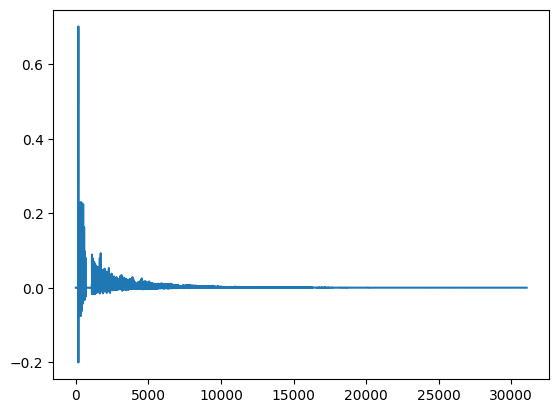

In [79]:
room.compute_rir()
plt.plot(room.rir[1][0])
plt.show()

# Plot the room output

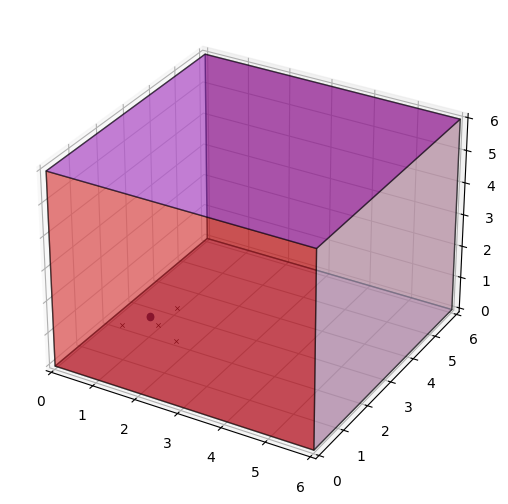

In [80]:
room.plot(img_order=0)
plt.show()

# Simulate sound propagation

The desired RT60 was 0.5
The measured RT60 is 0.4916780045351474


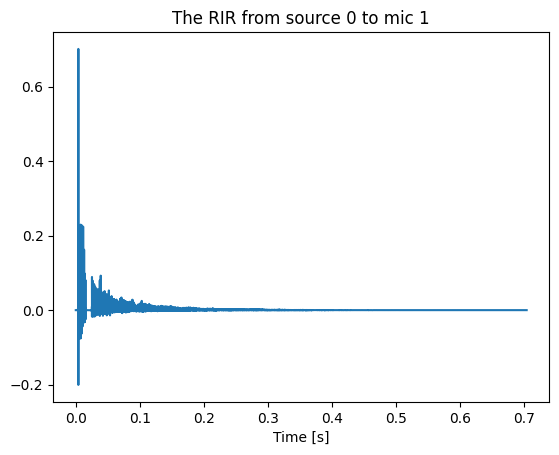

[[-2.79081647e-12 -1.67448988e-11 -1.11632659e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 8.54687545e-12  1.22970351e-11  7.67474530e-12 ... -7.53520448e-11
   5.58163294e-12  2.79081647e-12]
 [ 2.79081647e-12 -8.37244942e-12  5.58163294e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.51173483e-11  0.00000000e+00  5.58163294e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


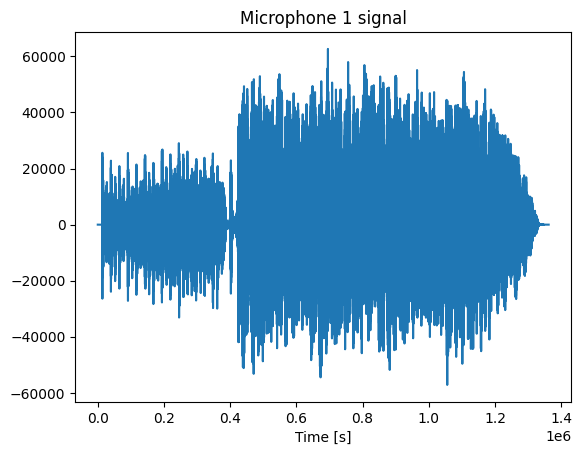

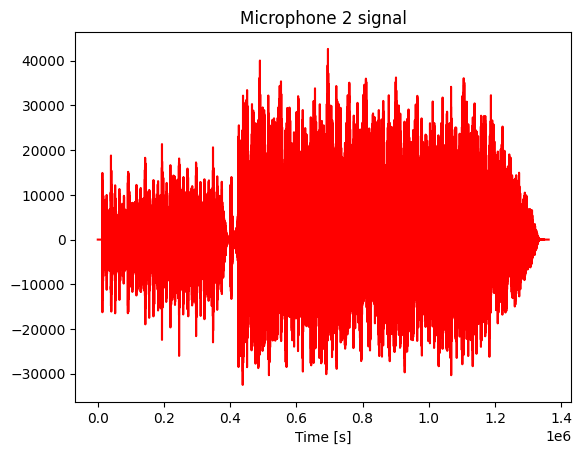

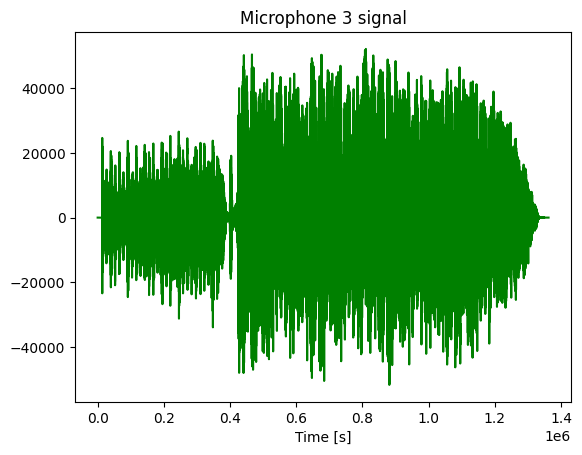

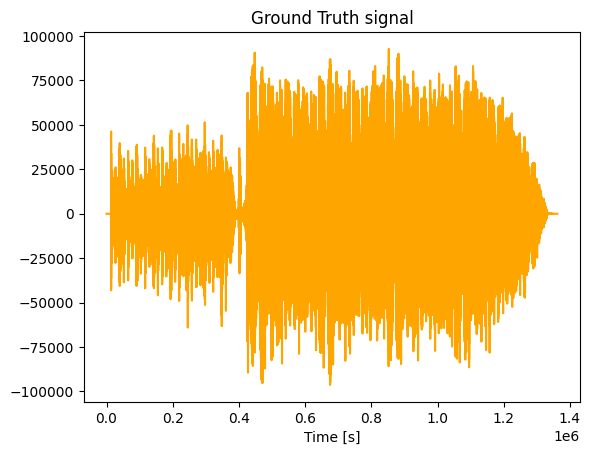

In [81]:
# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
# plt.subplot(5, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")
plt.show()

# Plotting individual signals

start = 10000
end = 12000

print(room.mic_array.signals)

# plot signal at microphone 1
mic_1_signal = room.mic_array.signals[0, :]
mic_1_signal_shortened = mic_1_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 2)
plt.plot(mic_1_signal)
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
mic_2_signal = room.mic_array.signals[1, :]
mic_2_signal_shortened = mic_2_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 3)
plt.plot(mic_2_signal, color='red')
plt.title("Microphone 2 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
mic_3_signal = room.mic_array.signals[2, :]
mic_3_signal_shortened = mic_3_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 4)
plt.plot(mic_3_signal, color='green')
plt.title("Microphone 3 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
mic_gt_signal = room.mic_array.signals[3, :]
mic_gt_signal_shortened = mic_gt_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 5)
plt.plot(mic_gt_signal, color='orange')
plt.title("Ground Truth signal")
plt.xlabel("Time [s]")
plt.show()

# Finding the time lag among the three different microphone recordings

I am performing a correlation on the FFT because time-domain cross-correlation is very computationally intensive. This is because it involves a series of multiplications and summations for every possible lag between the two signals. O(n^2).

FFT cross-correlation: Reduces computational complexity to O(n*logn)

Note: If we do the FFT correlation, we will need to account for the wrap-around effect. This is known as the circular or cyclic correlation, which is a phenomenon that occurs when we do cross-correlation on fourier transform of signals. 

Explanation: 

1) Linear Correlation: Imagine sliding one signal across another from left to right, and then we meaasure the overlap at each step. When we reach one end of the signal, the correlation ends. 
2) Circular Correlation: Instead of stopping at the end, the signal now wraps around to the beginning, continuing the sliding and measuring process. Thus, if one signal is delayed significantly compared to another, instead of seeing this as a large positive lag, we might interpret this as a negative lag as the signal is "wrapped around". 


In [82]:
# Performing fourier transform on the omnidirectional signals
f_mic1 = np.fft.fft(mic_1_signal)
f_mic2 = np.fft.fft(mic_2_signal)
f_mic3 = np.fft.fft(mic_3_signal)

# Calculate the cross-correlation in the frequency domain
correlation12 = np.fft.ifft(f_mic1 * np.conj(f_mic2))
correlation13 = np.fft.ifft(f_mic1 * np.conj(f_mic3))
correlation23 = np.fft.ifft(f_mic2 * np.conj(f_mic3))

# Find the lag with maximum correlation
lag12 = np.argmax(np.abs(correlation12))
lag13 = np.argmax(np.abs(correlation13))
lag23 = np.argmax(np.abs(correlation23))

# Adjust for potential wrap-around effect
# 
N = len(mic_1_signal)
lag12 = lag12 if lag12 <= N // 2 else lag12 - N
lag13 = lag13 if lag13 <= N // 2 else lag13 - N
lag23 = lag23 if lag23 <= N // 2 else lag23 - N

# Calculate time delays
delay12 = lag12 / fs
delay13 = lag13 / fs
delay23 = lag23 / fs

# Positive delay: Mic 1 delayed relative to Mic 2
# Negative delay: Mic 2 delayed relative to Mic 1
print(f'Time delay between mic1 and mic2: {delay12:.5f} seconds')
print(f'Time delay between mic1 and mic3: {delay13:.5f} seconds')
print(f'Time delay between mic2 and mic3: {delay23:.5f} seconds')

Time delay between mic1 and mic2: -0.00132 seconds
Time delay between mic1 and mic3: -0.00014 seconds
Time delay between mic2 and mic3: 0.00118 seconds


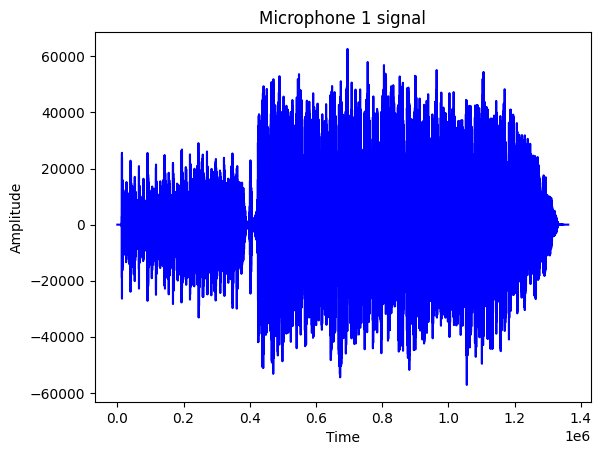

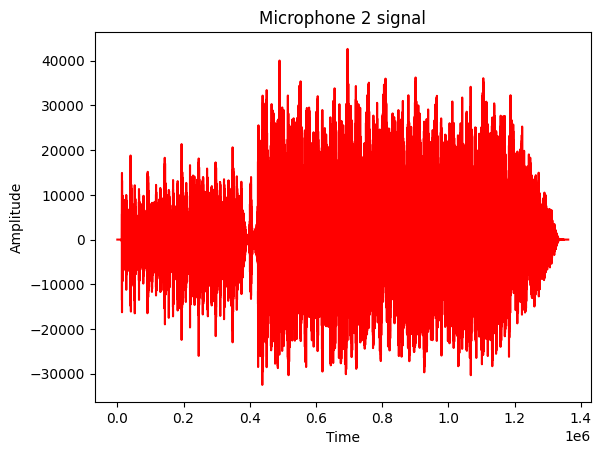

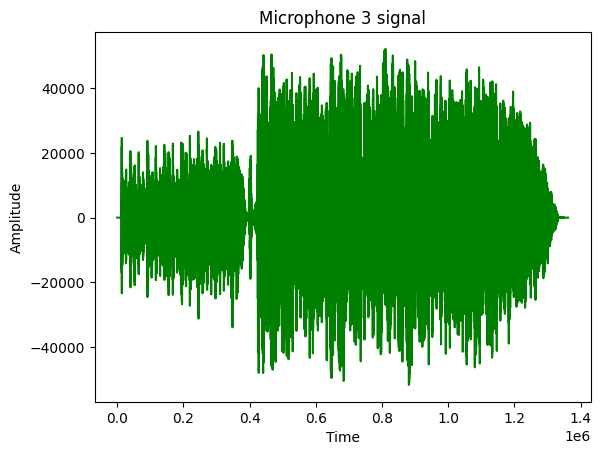

In [83]:
# Convert time delays to sample indices
delay12_samples = int(round(delay12 * fs))
delay13_samples = int(round(delay13 * fs))
delay23_samples = delay12_samples - delay13_samples  # Derived from delay12 and delay13

# Find the maximum delay to align signals
max_delay_samples = max(0, delay12_samples, delay13_samples, -delay23_samples)

# Initialize the array to store aligned signals
aligned_signals = []

# Align each signal based on the calculated delays
for i, signal in enumerate([mic_1_signal, mic_2_signal, mic_3_signal]):
    if i == 0:  # mic 1
        delay = max_delay_samples - 0
    elif i == 1:  # mic 2
        delay = max_delay_samples - delay12_samples
    else:  # mic 3
        delay = max_delay_samples - delay13_samples

    # Apply the delay (pad with zeros at the beginning and trim the end)
    padded_signal = np.pad(signal, (delay, 0), mode='constant', constant_values=0)
    aligned_signals.append(padded_signal[:len(signal)])

# Now you have aligned_signals[0], aligned_signals[1], and aligned_signals[2]
# corresponding to the aligned signals for mic_1, mic_2, and mic_3

mic_1_aligned = aligned_signals[0]
mic_2_aligned = aligned_signals[1]
mic_3_aligned = aligned_signals[2]

# Plotting each of the signals
def plot_signal(time, signal, title, color='blue'):
    plt.plot(time, signal, color)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

mic_1_time = np.arange(1, mic_1_aligned.shape[0] + 1)
mic_2_time = np.arange(1, mic_2_aligned.shape[0] + 1)
mic_3_time = np.arange(1, mic_3_aligned.shape[0] + 1)
assert(len(mic_1_time) == len(mic_2_time) == len(mic_3_time))

plot_signal(mic_1_time, mic_1_aligned, 'Microphone 1 signal', color='blue')
plot_signal(mic_2_time, mic_2_aligned, 'Microphone 2 signal', color='red')
plot_signal(mic_3_time, mic_3_aligned, 'Microphone 3 signal', color='green')



# Analysis of the simulations

Able to successfully print out what each microphone hears. 

In [84]:
# from scipy.io import wavfile
# fs, audio = wavfile.read('generated_mics/mic_arr.wav')

# # Define start and end point
# start = 10000
# end = 12000

# # Getting each of the individual components (Omnidirectional components)
# mic_1_signal  = audio[:, 0]
# mic_2_signal  = audio[:, 1]
# mic_3_signal  = audio[:, 2]
# mic_gt_signal = audio[:, 3]

# # Shortening each of the signals
# mic_1_signal_shortened = mic_1_signal[start:end]
# mic_2_signal_shortened = mic_2_signal[start:end]
# mic_3_signal_shortened = mic_3_signal[start:end]
# mic_gt_signal_shortened = mic_gt_signal[start:end]

# # Plotting each of the signals
# def plot_signal(time, signal, title, color='blue'):
#     plt.plot(time, signal, color)
#     plt.title(title)
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.show()

# # Plotting each of the signals
# time_axis = np.arange(1, mic_1_signal_shortened.shape[0] + 1)

# plot_signal(time_axis, mic_1_signal_shortened, 'Microphone 1 signal', color='blue')
# plot_signal(time_axis, mic_2_signal_shortened, 'Microphone 2 signal', color='green')
# plot_signal(time_axis, mic_3_signal_shortened, 'Microphone 3 signal', color='red')
# plot_signal(time_axis, mic_gt_signal_shortened, 'Ground Truth signal', color='orange')

# Applying the Interpolation Algorithm
In this section, we will apply the interpolation algorithm for the omnidirectional component. 

In [85]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 1

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = L

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 3))

mic_positions[0, :] = mic_1_pos
mic_positions[1, :] = mic_2_pos
mic_positions[2, :] = mic_3_pos


# Defining certain functions

In [86]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, y_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, z_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))


# Interpolation algorithm
We want to perform interpolation to form the omnidirectional component's at the centroid

[[1.]
 [1.]
 [1.]]
Interpolated signal: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.64230894e-06
  1.20570004e-06 -1.20580051e-06]


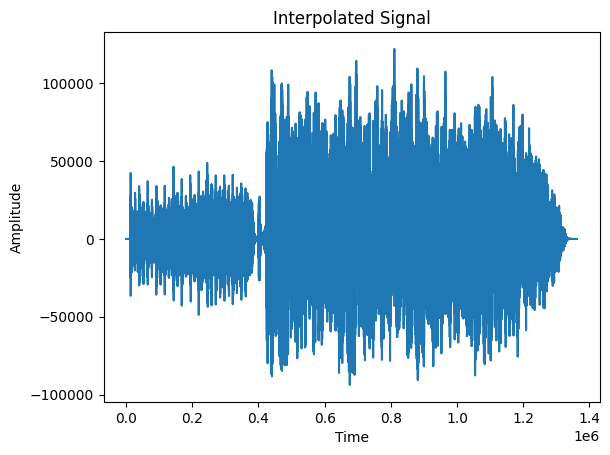

In [87]:
# In this case, y_m_p is just the 
max_samples = mic_gt_signal.shape[0]# Sample size of mic_gt_signal
y_m_p = np.zeros((M, P, max_samples))  # Initialize with the maximum number of samples

# Interpolation point will be the same point as the ground truth microphone
interp_point = np.array(mic_gt_pos)

# Compute the distance for all samples at once (This is the d_m function)
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])

# Compute the attenuation coefficients for each microphone using broadcasting (This calculates the a_p(d_m))
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
print(a_p_values)

# Fitting the y_m_p (p = 1, m is the mic)
y_1_1 = mic_1_aligned
y_2_1 = mic_2_aligned
y_3_1 = mic_3_aligned

# Getting the attenuation values (a1_dm)
a1_d1 = a_p_values[0, :]
a1_d2 = a_p_values[1, :]
a1_d3 = a_p_values[2, :]

x_p = a1_d1 * y_1_1 + a1_d2 * y_2_1 + a1_d3 * y_3_1
print(f"Interpolated signal: {x_p}")
x_p_shortened = x_p

# Plotting x_p
time_axis = np.arange(1, 1 + x_p_shortened.shape[0])
wavfile.write('generated_mics/output_median4.wav', fs, x_p)
plt.plot(time_axis, x_p_shortened)
plt.title('Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Checking if the centroid is the most like the ground truth by doing a cross-correlation graph

In [88]:
# Performing cross correlation
from scipy.signal import correlate

# 1. Creating an array of y-value points (From y = 0 to y = 3)
# We expect 1.5 to be the highest
points = np.arange(0, 3, 0.15)
num_points = len(points)
signals = []

# Array of cross correlation values
cross_corr_values = []

# Getting the values of cross_correlations
for i in range(num_points):
    y_point = points[i]
    interp_point = np.array([mic_gt_pos[0], y_point, mic_gt_pos[2]])
    distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
    a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])

    # Getting the attenuation values (a1_dm)
    a1_d1 = a_p_values[0, :]
    a1_d2 = a_p_values[1, :]
    a1_d3 = a_p_values[2, :]

    x_p = a1_d1 * y_1_1 + a1_d2 * y_2_1 + a1_d3 * y_3_1

    # Normalizing x_p
    # x_p_normalized = (x_p - np.mean(x_p)) / np.std(x_p)
    x_p_normalized = x_p
    signals.append(x_p_normalized)

    # signals.append(x_p)
# Normalize the ground truth signal
# gt_signal_normalized = (mic_gt_signal - np.mean(mic_gt_signal)) / np.std(mic_gt_signal)
gt_signal_normalized = mic_gt_signal

# Cross correlating the signals
for signal in signals:
    cross_corr = correlate(gt_signal_normalized, signal, mode='full')
    cross_corr_values.append(cross_corr)

# Identifying time shifts
time_shifts = [np.argmax(cross_corr) - (len(gt_signal_normalized) - 1) for cross_corr in cross_corr_values]

# Quantifying similarities
max_corr_values = [np.max(cross_corr) for cross_corr in cross_corr_values]
print(f"Max correlation values: {max_corr_values}")

most_similar_index = np.argmax(max_corr_values)
most_similar_signal = signals[most_similar_index]

# We expect it to say 55
print(f"The most signal is the one with y value: {points[most_similar_index]}")


Max correlation values: [343128822804760.9, 350788990415567.94, 358462333409165.2, 364653207772297.1, 369805612864231.25, 375139084634705.9, 378956087896069.1, 381759193380252.5, 384611127185307.6, 384774456296958.3, 384774456296958.3, 384468542754323.2, 381671494816316.7, 378698827880541.25, 375618211788219.94, 370019348575213.0, 364502799835881.7, 360320687021245.94, 356211976949782.6, 352189808218473.2]
The most signal is the one with y value: 1.3499999999999999


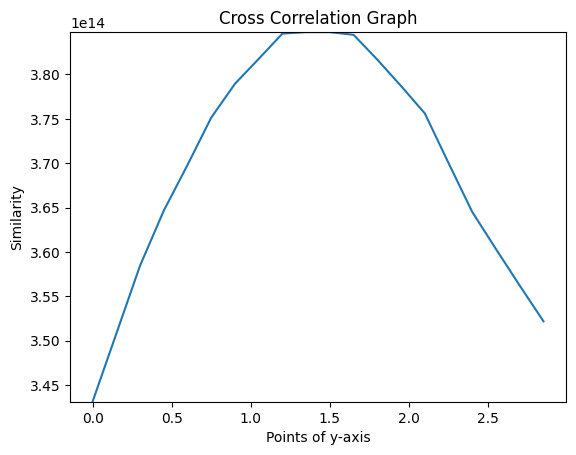

In [89]:
# Normalize the max_corr_values:

# Plotting the graph
plt.plot(points, max_corr_values)
lower_bound = np.min(max_corr_values) - 0.0000000001
upper_bound = np.max(max_corr_values) + 0.0000000001
plt.ylim(lower_bound, upper_bound)
plt.title("Cross Correlation Graph")
plt.xlabel("Points of y-axis")
plt.ylabel("Similarity")
plt.show()
